In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
!ls gdrive/MyDrive/datasets/ham10000

HAM10000_images_part_1	HAM10000_images_part_2	HAM10000_metadata.csv


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(0)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [4]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [5]:
base_skin_dir = os.path.join('', 'gdrive/MyDrive/datasets/ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [9]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
skin_df.head(20)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2


In [7]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [9]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [10]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


<Axes: >

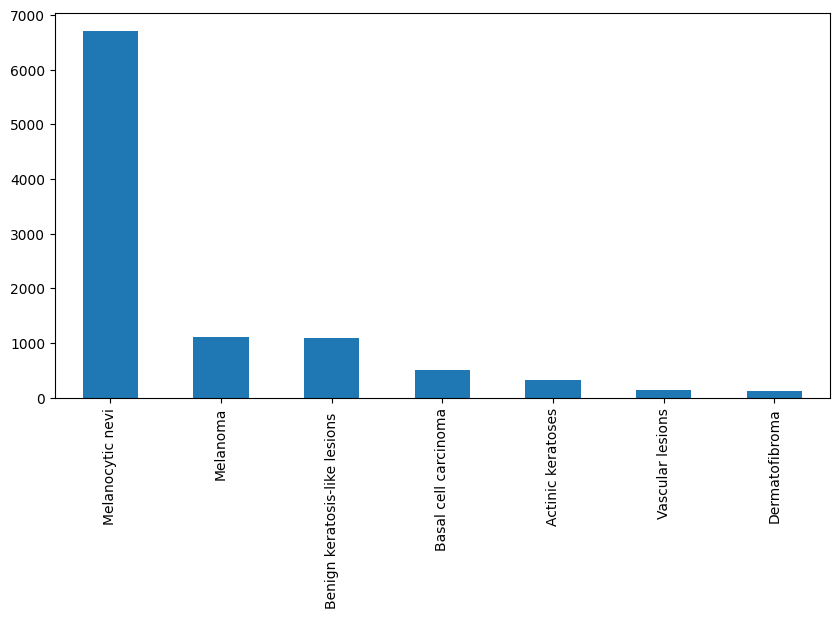

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<Axes: >

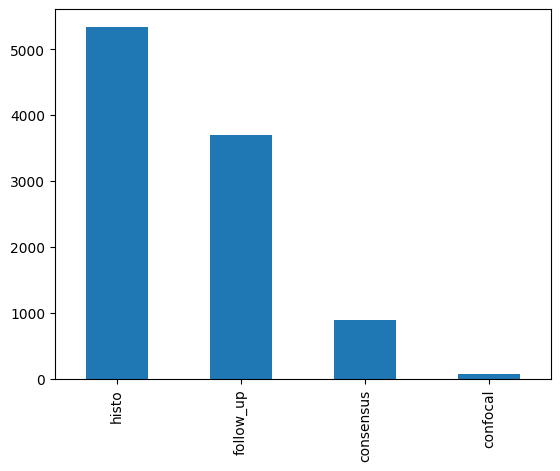

In [ ]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<Axes: >

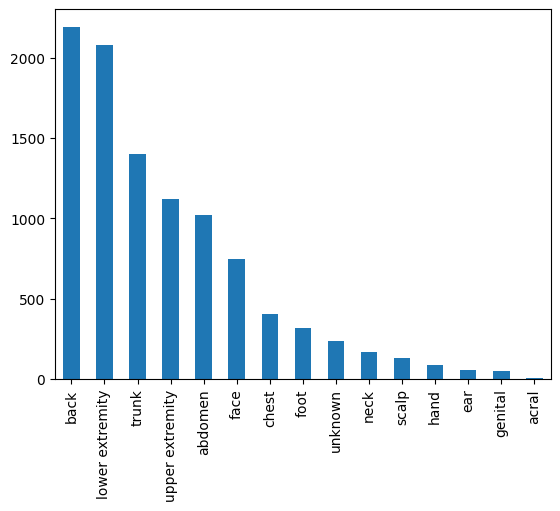

In [ ]:
skin_df['localization'].value_counts().plot(kind='bar')

<Axes: >

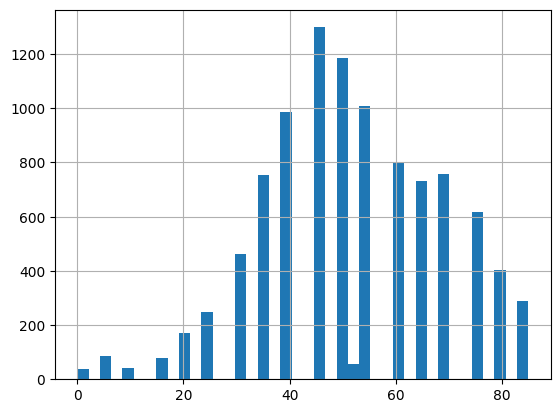

In [ ]:
skin_df['age'].hist(bins=40)

<Axes: >

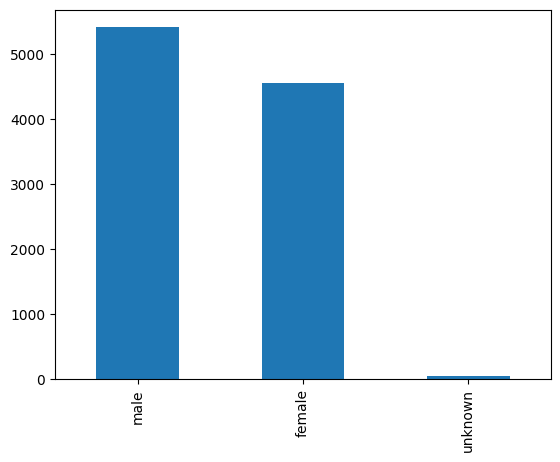

In [ ]:
skin_df['sex'].value_counts().plot(kind='bar')

In [10]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

In [12]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
image             object
dtype: object


In [ ]:
skin_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/ham10000_224_224.csv')

In [15]:
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ham10000_224_224.csv')
test = test.drop(['Unnamed: 0'], axis=1)

In [13]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,gdrive/MyDrive/datasets/ham10000/HAM10000_imag...,Benign keratosis-like lesions,2,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."


In [14]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=0).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

Output hidden; open in https://colab.research.google.com to view.

In [11]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(100, 100, 3)    10015
Name: image, dtype: int64

In [12]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [13]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=0)

In [14]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

In [15]:
import torch
import torchvision.datasets

In [16]:
X_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train_o.to_numpy())
X_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test_o.to_numpy())

In [14]:
X_train.shape, y_train.shape

(torch.Size([8012, 224, 224, 3]), torch.Size([8012]))

In [17]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [18]:
X_train /= 255.
X_test /= 255.

In [19]:
import torch
import random
import numpy as np
import pandas as pd

import torchvision.datasets
from tqdm import tqdm

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [24]:
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks')

In [25]:
import pytorch_optimizer as optim

In [46]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(net.parameters(), lr=5.0e-2)
    #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    #optimizer = optim.PNMBelief(net.parameters(), lr=0.001)
    #optimizer = optim.YogiPNM(net.parameters())
    #optimizer = optim.AdaBelief(net.parameters())
    optimizer = optim.DiffGrad(net.parameters())
    #optimizer = optim.Yogi(net.parameters())
    
    batch_size = 9

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(20):
        print("epoch ", epoch)
        order = np.random.permutation(len(X_train))
        
        if epoch == 12:
            #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-5)
            #optimizer = optim.PNMBelief(net.parameters(), lr=1.0e-4)
            #optimizer = optim.YogiPNM(net.parameters(), lr=1.0e-4)
            #optimizer = optim.AdaBelief(net.parameters(), lr=1.0e-4)
            optimizer = optim.DiffGrad(net.parameters(), lr=1.0e-4)
            #optimizer = optim.Yogi(net.parameters(), lr=1.0e-4)
    

        for start_index in tqdm(range(0, len(X_train), batch_size)):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
            #print(test_preds.argmax(dim=1))
            #print(y_test)

        print("accuracy = ", accuracy)
        print("\n\n")

    return test_accuracy_history, test_loss_history

In [21]:
accuracies = {}
losses = {}

In [22]:
from torchvision.models import resnet50, ResNet50_Weights

In [23]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+Adam'], losses['resnet50+Adam'] = \
    train(model, X_train, y_train, X_test, y_test)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch  0


100%|██████████| 401/401 [00:40<00:00,  9.91it/s]


accuracy =  0.7568647265434265



epoch  1


100%|██████████| 401/401 [00:33<00:00, 12.13it/s]


accuracy =  0.778332531452179



epoch  2


100%|██████████| 401/401 [00:33<00:00, 11.89it/s]


accuracy =  0.7603594660758972



epoch  3


100%|██████████| 401/401 [00:34<00:00, 11.59it/s]


accuracy =  0.7713429927825928



epoch  4


100%|██████████| 401/401 [00:34<00:00, 11.60it/s]


accuracy =  0.7708437442779541



epoch  5


100%|██████████| 401/401 [00:34<00:00, 11.60it/s]


accuracy =  0.7768347263336182



epoch  6


100%|██████████| 401/401 [00:34<00:00, 11.57it/s]


accuracy =  0.7618572115898132



epoch  7


100%|██████████| 401/401 [00:34<00:00, 11.63it/s]


accuracy =  0.7883175015449524



epoch  8


100%|██████████| 401/401 [00:34<00:00, 11.58it/s]


accuracy =  0.7059410810470581



epoch  9


100%|██████████| 401/401 [00:34<00:00, 11.49it/s]


accuracy =  0.7538691759109497



epoch  10


100%|██████████| 401/401 [00:34<00:00, 11.64it/s]


accuracy =  0.778332531452179



epoch  11


100%|██████████| 401/401 [00:34<00:00, 11.62it/s]


accuracy =  0.7448827028274536



epoch  12


100%|██████████| 401/401 [00:34<00:00, 11.59it/s]


accuracy =  0.7903145551681519



epoch  13


100%|██████████| 401/401 [00:38<00:00, 10.32it/s]


accuracy =  0.7918123006820679



epoch  14


100%|██████████| 401/401 [00:40<00:00,  9.99it/s]


accuracy =  0.7958062887191772



epoch  15


100%|██████████| 401/401 [00:40<00:00,  9.99it/s]


accuracy =  0.800798773765564



epoch  16


100%|██████████| 401/401 [00:39<00:00, 10.16it/s]


accuracy =  0.8067898154258728



epoch  17


100%|██████████| 401/401 [00:34<00:00, 11.60it/s]


accuracy =  0.8077883124351501



epoch  18


100%|██████████| 401/401 [00:38<00:00, 10.47it/s]


accuracy =  0.8062905669212341



epoch  19


100%|██████████| 401/401 [00:34<00:00, 11.50it/s]


accuracy =  0.8072890639305115





In [31]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+PNMBelief'], losses['resnet50+PNMBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 891/891 [01:09<00:00, 12.81it/s]


accuracy =  0.7403894066810608



epoch  1


100%|██████████| 891/891 [01:05<00:00, 13.61it/s]


accuracy =  0.7883175015449524



epoch  2


100%|██████████| 891/891 [01:04<00:00, 13.73it/s]


accuracy =  0.750374436378479



epoch  3


100%|██████████| 891/891 [01:04<00:00, 13.79it/s]


accuracy =  0.7738392353057861



epoch  4


100%|██████████| 891/891 [01:05<00:00, 13.54it/s]


accuracy =  0.7803295254707336



epoch  5


100%|██████████| 891/891 [01:04<00:00, 13.74it/s]


accuracy =  0.7758362293243408



epoch  6


100%|██████████| 891/891 [01:05<00:00, 13.68it/s]


accuracy =  0.785821259021759



epoch  7


100%|██████████| 891/891 [01:04<00:00, 13.80it/s]


accuracy =  0.7338991761207581



epoch  8


100%|██████████| 891/891 [01:05<00:00, 13.59it/s]


accuracy =  0.779830276966095



epoch  9


100%|██████████| 891/891 [01:04<00:00, 13.74it/s]


accuracy =  0.7363954186439514



epoch  10


100%|██████████| 891/891 [01:05<00:00, 13.56it/s]


accuracy =  0.7943085432052612



epoch  11


100%|██████████| 891/891 [01:11<00:00, 12.55it/s]


accuracy =  0.7928107976913452



epoch  12


100%|██████████| 891/891 [01:14<00:00, 11.94it/s]


accuracy =  0.7983025312423706



epoch  13


100%|██████████| 891/891 [01:07<00:00, 13.15it/s]


accuracy =  0.7968047857284546



epoch  14


100%|██████████| 891/891 [01:08<00:00, 13.08it/s]


accuracy =  0.8027958273887634



epoch  15


100%|██████████| 891/891 [01:19<00:00, 11.26it/s]


accuracy =  0.8112830519676208



epoch  16


100%|██████████| 891/891 [01:06<00:00, 13.48it/s]


accuracy =  0.8217673301696777



epoch  17


100%|██████████| 891/891 [01:05<00:00, 13.59it/s]


accuracy =  0.8107838034629822



epoch  18


100%|██████████| 891/891 [01:06<00:00, 13.41it/s]


accuracy =  0.8132801055908203



epoch  19


100%|██████████| 891/891 [01:06<00:00, 13.36it/s]


accuracy =  0.8212680816650391





In [40]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+Yogi'], losses['resnet50+Yogi'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 891/891 [00:56<00:00, 15.78it/s]


accuracy =  0.7648527026176453



epoch  1


100%|██████████| 891/891 [00:59<00:00, 15.04it/s]


accuracy =  0.7748377323150635



epoch  2


100%|██████████| 891/891 [00:56<00:00, 15.76it/s]


accuracy =  0.7678482532501221



epoch  3


100%|██████████| 891/891 [00:57<00:00, 15.52it/s]


accuracy =  0.7918123006820679



epoch  4


100%|██████████| 891/891 [00:56<00:00, 15.81it/s]


accuracy =  0.7878182530403137



epoch  5


100%|██████████| 891/891 [00:56<00:00, 15.81it/s]


accuracy =  0.7753369808197021



epoch  6


100%|██████████| 891/891 [00:57<00:00, 15.62it/s]


accuracy =  0.7978032827377319



epoch  7


100%|██████████| 891/891 [00:56<00:00, 15.75it/s]


accuracy =  0.7523714303970337



epoch  8


100%|██████████| 891/891 [00:56<00:00, 15.73it/s]


accuracy =  0.7748377323150635



epoch  9


100%|██████████| 891/891 [00:57<00:00, 15.61it/s]


accuracy =  0.7888167500495911



epoch  10


100%|██████████| 891/891 [00:56<00:00, 15.81it/s]


accuracy =  0.8077883124351501



epoch  11


100%|██████████| 891/891 [00:56<00:00, 15.70it/s]


accuracy =  0.8062905669212341



epoch  12


100%|██████████| 891/891 [00:56<00:00, 15.87it/s]


accuracy =  0.8242636322975159



epoch  13


100%|██████████| 891/891 [00:57<00:00, 15.56it/s]


accuracy =  0.8247628808021545



epoch  14


100%|██████████| 891/891 [00:56<00:00, 15.73it/s]


accuracy =  0.8222665786743164



epoch  15


100%|██████████| 891/891 [00:56<00:00, 15.72it/s]


accuracy =  0.8232650756835938



epoch  16


100%|██████████| 891/891 [00:57<00:00, 15.46it/s]


accuracy =  0.8267598748207092



epoch  17


100%|██████████| 891/891 [00:57<00:00, 15.57it/s]


accuracy =  0.8177733421325684



epoch  18


100%|██████████| 891/891 [00:56<00:00, 15.72it/s]


accuracy =  0.8237643837928772



epoch  19


100%|██████████| 891/891 [00:57<00:00, 15.61it/s]


accuracy =  0.8172740936279297





In [47]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+DiffGrad'], losses['resnet50+DiffGrad'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 891/891 [01:13<00:00, 12.20it/s]


accuracy =  0.7673490047454834



epoch  1


100%|██████████| 891/891 [01:13<00:00, 12.13it/s]


accuracy =  0.7598602175712585



epoch  2


100%|██████████| 891/891 [01:08<00:00, 12.96it/s]


accuracy =  0.7788317799568176



epoch  3


100%|██████████| 891/891 [01:10<00:00, 12.66it/s]


accuracy =  0.7888167500495911



epoch  4


100%|██████████| 891/891 [01:09<00:00, 12.88it/s]


accuracy =  0.7868197560310364



epoch  5


100%|██████████| 891/891 [01:08<00:00, 13.03it/s]


accuracy =  0.7838242650032043



epoch  6


100%|██████████| 891/891 [01:09<00:00, 12.80it/s]


accuracy =  0.7898153066635132



epoch  7


100%|██████████| 891/891 [01:08<00:00, 12.95it/s]


accuracy =  0.7683475017547607



epoch  8


100%|██████████| 891/891 [01:10<00:00, 12.67it/s]


accuracy =  0.7763354778289795



epoch  9


100%|██████████| 891/891 [01:08<00:00, 12.99it/s]


accuracy =  0.7793310284614563



epoch  10


100%|██████████| 891/891 [01:08<00:00, 12.97it/s]


accuracy =  0.7738392353057861



epoch  11


100%|██████████| 891/891 [01:09<00:00, 12.80it/s]


accuracy =  0.7693459987640381



epoch  12


100%|██████████| 891/891 [01:09<00:00, 12.90it/s]


accuracy =  0.8072890639305115



epoch  13


100%|██████████| 891/891 [01:08<00:00, 13.07it/s]


accuracy =  0.8037943243980408



epoch  14


100%|██████████| 891/891 [01:09<00:00, 12.77it/s]


accuracy =  0.8097853064537048



epoch  15


100%|██████████| 891/891 [01:09<00:00, 12.91it/s]


accuracy =  0.8057913184165955



epoch  16


100%|██████████| 891/891 [01:09<00:00, 12.78it/s]


accuracy =  0.8082875609397888



epoch  17


100%|██████████| 891/891 [01:08<00:00, 12.95it/s]


accuracy =  0.8147778511047363



epoch  18


100%|██████████| 891/891 [01:08<00:00, 13.00it/s]


accuracy =  0.8097853064537048



epoch  19


100%|██████████| 891/891 [01:10<00:00, 12.62it/s]


accuracy =  0.8107838034629822





In [26]:
APreds = pd.DataFrame()

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
test_preds = []
model.eval()
with torch.no_grad():
            test_preds = model.forward(X_test)

In [28]:
APreds['Adam'] = test_preds.argmax(dim=1).tolist()

In [35]:
APreds['PNMBelief'] = test_preds.argmax(dim=1).tolist()

In [42]:
APreds['Yogi'] = test_preds.argmax(dim=1).tolist()

In [49]:
APreds['DiffGrad'] = test_preds.argmax(dim=1).tolist()

In [50]:
APreds

,Adam,PNMBelief,Yogi,DiffGrad
0,4,4,4,4
1,4,4,4,4
2,4,4,4,4
3,0,4,4,2
4,4,4,4,2
...,...,...,...,...
1998,4,4,4,4
1999,4,5,4,4
2000,4,4,4,4
2001,4,4,4,4


In [ ]:
APreds = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ansambl_ham10000_v1.csv')
APreds = APreds.drop(['Unnamed: 0'], axis=1)

In [51]:
APreds.to_csv('/content/gdrive/MyDrive/Colab Notebooks/ansambl_ham10000_v1.csv')

In [ ]:
APreds

In [57]:
data = np.zeros((2003,7), dtype=int)
ARes = pd.DataFrame(data)

In [58]:
for i in range(2003):
    for j in range(4):
        if j == 0:
            ARes.iloc[i, APreds.iloc[i, j]%7] += 0.807289
        if j == 1:
            ARes.iloc[i, APreds.iloc[i, j]%7] += 0.821268
        if j == 2:
            ARes.iloc[i, APreds.iloc[i, j]%7] += 0.817274
        if j == 3:
            ARes.iloc[i, APreds.iloc[i, j]%7] += 0.8107838

In [59]:
anslist = ARes.idxmax(axis=1)

In [60]:
accuracy = (torch.tensor(anslist).to(device) == y_test).float().mean().item()

In [61]:
accuracy

0.8362456560134888

In [63]:
type(anslist.to_list())

list

In [52]:
data = np.zeros((10,10), dtype=int)
D = pd.DataFrame(data)

for x, y in zip(test_preds.argmax(dim=1).tolist(), y_test.tolist()):
    D[y][x] += 1


In [33]:
D #Adam

,0,1,2,3,4,5,6,7,8,9
0,22,8,5,4,3,7,0,0,0,0
1,13,74,3,2,6,8,2,0,0,0
2,16,5,112,3,36,22,1,0,0,0
3,0,1,1,13,1,1,0,0,0,0
4,4,13,51,4,1262,75,3,0,0,0
5,6,8,26,2,43,110,0,0,0,0
6,0,2,0,1,0,0,24,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [38]:
D #PNMBelief

,0,1,2,3,4,5,6,7,8,9
0,32,14,5,0,1,6,0,0,0,0
1,5,64,4,0,12,4,2,0,0,0
2,10,2,108,2,30,16,1,0,0,0
3,0,4,0,22,0,0,0,0,0,0
4,5,20,53,3,1272,72,3,0,0,0
5,9,6,28,2,34,123,0,0,0,0
6,0,1,0,0,2,2,24,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [44]:
D #Yogi

,0,1,2,3,4,5,6,7,8,9
0,34,6,11,3,4,10,0,0,0,0
1,8,74,4,1,12,5,2,0,0,0
2,9,9,105,2,25,16,0,0,0,0
3,0,2,0,16,1,0,0,0,0,0
4,3,14,54,4,1281,90,1,0,0,0
5,7,5,24,2,28,101,1,0,0,0
6,0,1,0,1,0,1,26,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [53]:
D #DiffGrad

,0,1,2,3,4,5,6,7,8,9
0,26,9,11,2,3,10,0,0,0,0
1,9,72,2,3,9,8,1,0,0,0
2,10,7,104,1,19,15,0,0,0,0
3,3,6,2,19,4,2,1,0,0,0
4,5,14,53,3,1273,81,3,0,0,0
5,8,1,26,0,39,105,0,0,0,0
6,0,2,0,1,4,2,25,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [64]:
data = np.zeros((10,10), dtype=int)
D = pd.DataFrame(data)

for x, y in zip(anslist.to_list(), y_test.tolist()):
    D[y][x] += 1

In [65]:
D #ansamble

,0,1,2,3,4,5,6,7,8,9
0,32,6,6,1,1,7,0,0,0,0
1,8,76,2,1,8,5,2,0,0,0
2,10,2,114,2,25,13,1,0,0,0
3,0,3,0,20,0,0,0,0,0,0
4,2,17,51,3,1291,80,2,0,0,0
5,9,6,25,1,24,117,0,0,0,0
6,0,1,0,1,2,1,25,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0
